# Calculating Power Spectrum of Maximum Temperature during MAM, JJAS and NDJF

#######PYTHON CODE FOR IMD PREPARED BY LEKSHMI S#############

########## https://doi.org/10.5281/zenodo.5674826 ############

In [1]:
###############Reading IMD binary (GRD) data for Maximum temperature###############

import numpy as np
import glob
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq

filename1='/mnt/d/DATA/IMD_MaxTemp/Maxtemp_MaxT_20*.GRD'	##File path

In [2]:
###############Have to set according to data format##############################

nlat=31				# Obtained from the ctl file
nlon=31
nyear=21
years=np.arange(2000,2021,1)
lons=np.arange(67.5,98.5,1)	# Define latitude and longitude as obtained from ctl file
#print(lons)
lats=np.arange(7.5,38.5,1)
#print(lats)

latbounds = [ 18.0 , 29.0 ]	#Lat-lon bound for Heat Wave (MZI)
lonbounds = [ 65.0 , 89.0 ] 	# degrees east 


In [3]:
######################Fixed for the looping#######################################

npos=59
jjas_days=122
mam_days=92
ndjf_days=120
ndjf_years=20
lp=0
nlp=0
lpdays=366
nlpdays=365
fill=99.9
a=0

MaxTemp=np.full([nyear,lpdays,nlat,nlon],fill,order='C')	# Create an empty 4d array to store data
na=np.full([nlat,nlon],fill,order='C')				# Array to be given for leap year day in non-leap years

####################Looping for reading maxtemp data#############################

for files in glob.glob(filename1):
	f=open(files,'rb')
	maxdata=np.fromfile(f,dtype="float32",count=-1)				#  Reading the file into a 1D array
	y=years[a]
	if (y%4==0):
		maxtemp=np.reshape(maxdata,(lpdays,nlat,nlon),order='C')	#Reading variable in required shape
		MaxTemp[a,:,:,:]=maxtemp					# Storing variable in the empty array
	else:
		maxtemp=np.reshape(maxdata,(nlpdays,nlat,nlon),order='C')
		maxtemp=np.insert(maxtemp,npos,na,axis=0)
		MaxTemp[a,:,:,:]=maxtemp					# Storing variable in the empty array
	a=a+1
#print(MaxTemp.shape)
del files
del f


In [4]:
##############Extract season data and lat-lon range for each year####################

latselect=np.logical_and(lats>=latbounds[0],lats<=latbounds[1])
lonselect=np.logical_and(lons>=lonbounds[0],lons<=lonbounds[1])

##############Extract seasons##########################
maxtemp_jjas=MaxTemp[:,152:274,:,:][:,:,latselect,:][:,:,:,lonselect]         # For JJAS
maxtemp_mam=MaxTemp[:,60:152,:,:][:,:,latselect,:][:,:,:,lonselect]           # For MAM

maxtemp_NDJF=np.full([ndjf_years,ndjf_days,nlat,nlon],fill,order='C')
maxtemp_nd=MaxTemp[:,305:365,:,:]
maxtemp_jf=MaxTemp[:,0:59,:,:]
maxtemp_NDJF[:,0:60,:,:]=maxtemp_nd[:nyear-1,:,:,:]
for i in range(1,nyear-1):
    maxtemp_NDJF[i,61:,:,:]=maxtemp_jf[i+1,:,:,:]
maxtemp_ndjf=maxtemp_NDJF[:,:,latselect,:][:,:,:,lonselect]                   # For NDJF

############JJAS
tmax_mask1=np.ma.masked_where(maxtemp_jjas>99.0, maxtemp_jjas)                              #Mask the fill values
tmax_anom1=np.empty([nyear,jjas_days,tmax_mask1.shape[2],tmax_mask1.shape[3]],order='C')    #Create empty array to store anomaly
tmax_anom_mask1=np.ma.masked_where(maxtemp_jjas>99.0,tmax_anom1)          #Mask anomaly array where maxtemp_jjas has fill values

for i in range(0,tmax_mask1.shape[0]):
    tmax_anom_mask1[i,:,:,:]=tmax_mask1[i,:,:,:]-(np.mean(tmax_mask1,axis=0))              #Calculate anomaly for each year

tmax1=np.mean(tmax_anom_mask1,axis=(2,3))                                                  #Averaging over MZI

############MAM
tmax_mask2=np.ma.masked_where(maxtemp_mam>99.0, maxtemp_mam)                              
tmax_anom2=np.empty([nyear,mam_days,tmax_mask2.shape[2],tmax_mask2.shape[3]],order='C')      
tmax_anom_mask2=np.ma.masked_where(maxtemp_mam>99.0,tmax_anom2)                     

for i in range(0,tmax_mask2.shape[0]):
    tmax_anom_mask2[i,:,:,:]=tmax_mask2[i,:,:,:]-(np.mean(tmax_mask2,axis=0))    
tmax2=np.mean(tmax_anom_mask2,axis=(2,3))       

###########NDJF
tmax_mask3=np.ma.masked_where(maxtemp_ndjf>99.0, maxtemp_ndjf)                              
tmax_anom3=np.empty([ndjf_years,ndjf_days,tmax_mask3.shape[2],tmax_mask3.shape[3]],order='C')      
tmax_anom_mask3=np.ma.masked_where(maxtemp_ndjf>99.0,tmax_anom3)                    

for i in range(0,tmax_mask3.shape[0]):
    tmax_anom_mask3[i,:,:,:]=tmax_mask3[i,:,:,:]-(np.mean(tmax_mask3,axis=0))    

tmax3=np.mean(tmax_anom_mask3,axis=(2,3))  
print(tmax3.min())
print(tmax3.max())

-5.388395453301449
4.687805284964799


In [5]:
##############Calculate power spectrum for each year in JJAS#################################
fft_vals_jjas=np.empty([nyear,jjas_days],order='C',dtype='complex_')                    #To store Fourier transform
ps_jjas=np.empty([nyear,jjas_days],order='C')                                           #To store power spectrum
freqs_jjas=fftfreq(jjas_days)                                                           # Calculate frequency
mask_jjas=freqs_jjas>0                                                                  # mask where frequency is negative

for i in range(0,tmax1.shape[0]):
    fft_vals_jjas[i,:]=fft(tmax1[i,:])                                               #calculate Fourier transform for each year
    ps_jjas[i,:]=2.0*((np.abs(fft_vals_jjas[i,:])/jjas_days)**2.0)                   #Calculate power spectrum for each year
    mean_jjas=np.mean(tmax1[i,:]) 
    std_jjas=np.std(tmax1[i,:])
    var_jjas=std_jjas**2
    print(var_jjas)
    print(np.sum(ps_jjas[i,mask_jjas]))             # Sum of all power spectral density should be equal to variance of data

#print(np.sum(fft_vals_jjas[1,mask_jjas]))

ps_avg_jjas=np.mean(ps_jjas[:,mask_jjas],axis=0)                                       # Averaging power spectrum over all years

freq_mask_jjas=freqs_jjas[mask_jjas]

2.01191966639241
2.0100153415996314
3.0685388700889202
3.0678525934196936
1.8320480178992993
1.8304033022215767
1.5329485681589998
1.5320942084263824
1.8204705328002713
1.8204705075335912
3.7633679917923106
3.7626725494323034
1.761579122615647
1.7615018764026962
0.9686632175397661
0.9686495318450862
2.2859812731993725
2.285875385619634
1.7321982297640193
1.7318817825089086
1.306156395919433
1.3055391290523342
1.0639861935856028
1.0638059751133495
1.7258238381045323
1.7257137494135926
1.4677782230322864
1.4676691691879276
1.8370211399338536
1.8369264682112216
1.2271883563859036
1.2271135826703397
0.6758947108552137
0.6754091828456993
1.1097043910632283
1.109645107486161
1.3857905980280474
1.3852415239019558
2.6682690205410444
2.6679927975220155
2.066050502662518
2.064853062519618


In [6]:
##############Calculate power spectrum for each year in MAM#################################
fft_vals_mam=np.empty([nyear,mam_days],order='C',dtype='complex_')                    #To store Fourier transform
ps_mam=np.empty([nyear,mam_days],order='C')                                           #To store power spectrum
freqs_mam=fftfreq(mam_days)                                                           # Calculate frequency
mask_mam=freqs_mam>0                                                                  # mask where frequency is negative

for i in range(0,tmax2.shape[0]):
    fft_vals_mam[i,:]=fft(tmax2[i,:])                                               #calculate Fourier transform for each year
    ps_mam[i,:]=2.0*((np.abs(fft_vals_mam[i,:])/mam_days)**2.0)                   #Calculate power spectrum for each year
    
ps_avg_mam=np.mean(ps_mam[:,mask_mam],axis=0)                                       # Averaging power spectrum over all years

freq_mask_mam=freqs_mam[mask_mam]
print(ps_avg_mam.min())
print(ps_avg_mam.max())

0.0012176050020793134
0.35683307858676977


In [7]:
##############Calculate power spectrum for each year#################################

fft_vals_ndjf=np.empty([nyear,ndjf_days],order='C',dtype='complex_')		#To store Fourier transform
ps_ndjf=np.empty([nyear,ndjf_days],order='C')        #To store power spectrum
freqs_ndjf=fftfreq(ndjf_days)                        # Calculate frequency
mask_ndjf=freqs_ndjf>0                                    # mask where frequency is negative

for i in range(0,tmax3.shape[0]):
    fft_vals_ndjf[i,:]=fft(tmax3[i,:])            #calculate Fourier transform for each year
    ps_ndjf[i,:]=2.0*(np.abs(fft_vals_ndjf[i,:]/ndjf_days)**2.0)  #Calculate power spectrum for each year

ps_avg_ndjf=np.mean(ps_ndjf[:,mask_ndjf],axis=0)			# Averaging power spectrum over all years

print(ps_avg_ndjf.min())
print(ps_avg_ndjf.max())

0.0005563443396040394
0.35490330429743006


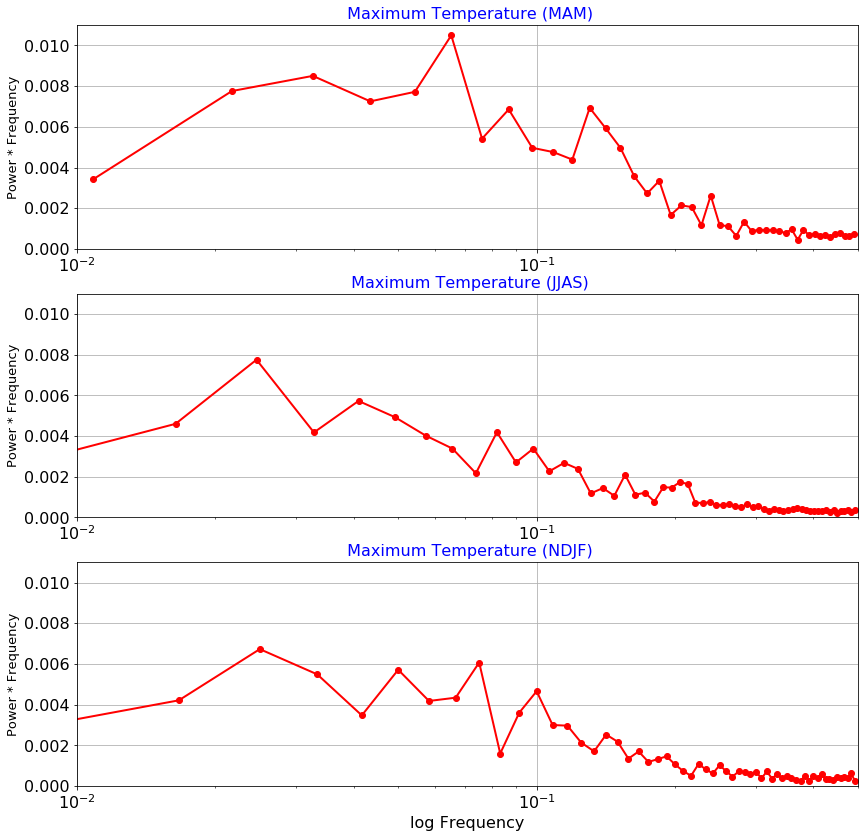

In [10]:
####################################Plotting Resources###############################

fig,(ax2,ax1,ax3) =plt.subplots(3,1,figsize=(14,14))
#ax1=fig1.add_subplot(1,1,1)
ax1.plot(freqs_jjas[mask_jjas],ps_avg_jjas*freqs_jjas[mask_jjas],linewidth=2.0,linestyle='-',color='r',label='Frequency vs Spectra',marker='o')
ax2.plot(freqs_mam[mask_mam],ps_avg_mam*freqs_mam[mask_mam],linewidth=2.0,linestyle='-',color='r',label='Frequency vs Spectra',marker='o')
ax3.plot(freqs_ndjf[mask_ndjf],ps_avg_ndjf*freqs_ndjf[mask_ndjf],linewidth=2.0,linestyle='-',color='r',label='Frequency vs Spectra',marker='o')
#ax.plot(freqs[mask],ci[:,0],linewidth=1.0,linestyle='--',color='black')
#ax.plot(freqs[mask],ci[:,1],linewidth=1.0,linestyle='--',color='black')

ax1.set_title(' Maximum Temperature (JJAS)', color='blue',fontsize=16)
ax1.set_ylabel('Power * Frequency',fontsize=13);   
ax1.set_xscale('log')
ax1.set_xlim(0.01,0.5)
ax1.set_ylim(0.0,0.011)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.grid(True)

ax2.set_title(' Maximum Temperature (MAM)', color='blue',fontsize=16)
ax2.set_ylabel('Power * Frequency',fontsize=13);   
ax2.set_xscale('log')
ax2.set_xlim(0.01,0.5)
ax2.set_ylim(0.0,0.011)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.grid(True)

ax3.set_title(' Maximum Temperature (NDJF)', color='blue',fontsize=16)
ax3.set_ylabel('Power * Frequency',fontsize=13);   
ax3.set_xlabel('log Frequency',fontsize=16)
ax3.set_xscale('log')
ax3.set_xlim(0.01,0.5)
ax3.set_ylim(0.0,0.011)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.grid(True)

plt.savefig('Max_temp_power_spectrum.png')